**1. Building a Data Pipeline**


In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Remove dodgy images**

In [4]:
import cv2
import imghdr
from matplotlib import pyplot as plt 

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']


In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

**Load Data**


In [8]:
import numpy as np
from matplotlib import pyplot as plt

**Charger les images depuis un dossier en tant que dataset TensorFlow**


In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 171 files belonging to 2 classes.


**Convertir le dataset en un itérateur Python**

In [10]:
data_iterator = data.as_numpy_iterator()

**Récupérer le premier batch d'images et de labels**

In [11]:
batch = data_iterator.next()

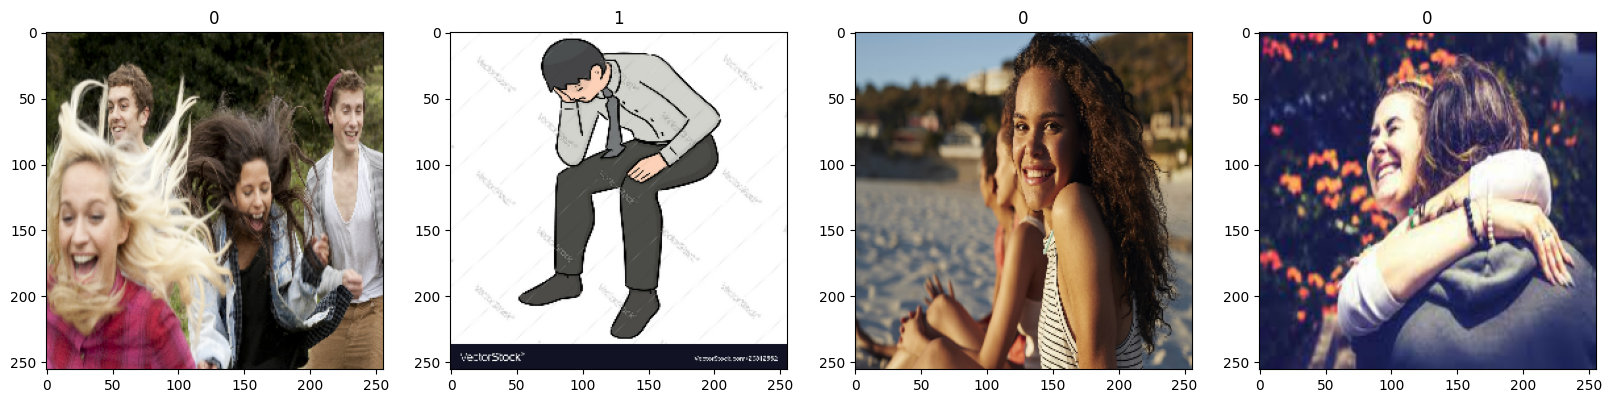

In [12]:
# Créer une figure avec 4 sous-graphes (colonnes) et une taille de figure de 20x20
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Parcourir les 4 premières images du batch (images du lot) et les afficher
for idx, img in enumerate(batch[0][:4]):
    # Afficher l'image actuelle en la convertissant en entier (pour un affichage correct)
    ax[idx].imshow(img.astype(int))

    # Définir le titre de chaque image avec le label correspondant du batch
    ax[idx].title.set_text(batch[1][idx])

**2. Preprocess Data**

**Scale Data**


In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()[0].min()

0.0

**Split Data**

In [15]:
len(data)

6

In [16]:
# Déterminer la taille de l'ensemble d'entraînement (70% des données)
train_size = int(len(data) * .7)  

# Déterminer la taille de l'ensemble de validation (20% des données)
val_size = int(len(data) * .2)  

# Déterminer la taille de l'ensemble de test (10% des données)
test_size = int(len(data) * .1)  


In [17]:
train_size

4

In [18]:
# Prendre les `train_size` premiers batches pour l'entraînement
train = data.take(train_size)

# Sauter les `train_size` premiers batches, puis prendre les `val_size` suivants pour la validation
val = data.skip(train_size).take(val_size)

# Sauter les `train_size + val_size` premiers batches, puis prendre les `test_size` suivants pour le test
test = data.skip(train_size + val_size).take(test_size)


**3. Build Deep Learning Model**

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()


In [21]:
# Ajouter la première couche convolutionnelle avec 16 filtres de taille 3x3
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Ajouter une couche de max-pooling pour réduire la taille des caractéristiques
model.add(MaxPooling2D())

# Ajouter la deuxième couche convolutionnelle avec 32 filtres de taille 3x3
model.add(Conv2D(32, (3,3), 1, activation='relu'))
# Ajouter une autre couche de max-pooling
model.add(MaxPooling2D())

# Ajouter la troisième couche convolutionnelle avec 16 filtres de taille 3x3
model.add(Conv2D(16, (3,3), 1, activation='relu'))
# Ajouter une couche de max-pooling
model.add(MaxPooling2D())

# Aplatir les cartes de caractéristiques pour les passer à la couche entièrement connectée
model.add(Flatten())

# Ajouter une couche dense avec 256 neurones et activation ReLU
model.add(Dense(256, activation='relu'))
# Ajouter la couche de sortie avec 1 neurone et activation sigmoïde pour la classification binaire
model.add(Dense(1, activation='sigmoid'))


In [22]:
# Compiler le modèle en spécifiant l'optimiseur, la fonction de perte et la métrique à utiliser pendant l'entraînement
model.compile(
    'adam',  # Utilisation de l'optimiseur Adam pour ajuster les poids pendant l'entraînement
    loss=tf.losses.BinaryCrossentropy(),  # Fonction de perte BinaryCrossentropy pour un problème de classification binaire
    metrics=['accuracy']  # Mesurer l'exactitude (accuracy) pour évaluer les performances du modèle
)


In [23]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

**4. Train**

In [24]:
# Définir le répertoire où les logs de TensorBoard seront enregistrés
logdir = 'logs'

# Créer un callback TensorBoard pour suivre l'entraînement et visualiser les métriques dans TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Entraîner le modèle sur l'ensemble d'entraînement (train), avec 20 époques,
# en utilisant l'ensemble de validation (val) et en passant le callback TensorBoard
hist = model.fit(
    train,  # Données d'entraînement
    epochs=20,  # Nombre d'époques (passes sur les données)
    validation_data=val,  # Données de validation pour évaluer la performance après chaque époque
    callbacks=[tensorboard_callback]  # Callback TensorBoard pour enregistrer les logs et visualiser l'entraînement
)


Epoch 1/20
4/4 [==============================] - 8s 631ms/step - loss: 1.1362 - accuracy: 0.5078 - val_loss: 0.8477 - val_accuracy: 0.3438
Epoch 2/20
4/4 [==============================] - 3s 560ms/step - loss: 0.7382 - accuracy: 0.3750 - val_loss: 0.6877 - val_accuracy: 0.6562
Epoch 3/20
4/4 [==============================] - 3s 528ms/step - loss: 0.6841 - accuracy: 0.7891 - val_loss: 0.5960 - val_accuracy: 0.8750
Epoch 4/20
4/4 [==============================] - 3s 550ms/step - loss: 0.6376 - accuracy: 0.6094 - val_loss: 0.5942 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 3s 551ms/step - loss: 0.6079 - accuracy: 0.6719 - val_loss: 0.4229 - val_accuracy: 0.8438
Epoch 6/20
4/4 [==============================] - 3s 525ms/step - loss: 0.5170 - accuracy: 0.7109 - val_loss: 0.5937 - val_accuracy: 0.5938
Epoch 7/20
4/4 [==============================] - 3s 534ms/step - loss: 0.5194 - accuracy: 0.6953 - val_loss: 0.4050 - val_accuracy: 0.7500
Epoch 8/20
4/4 [====

**5. Plot Performance**

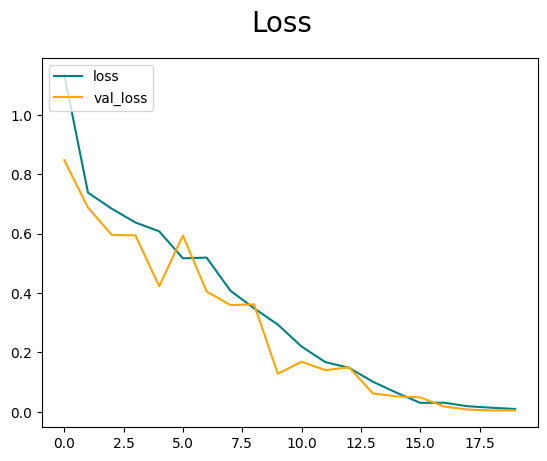

In [25]:
# Créer une nouvelle figure pour le graphique
fig = plt.figure()

# Tracer la courbe de la perte (loss) sur l'ensemble d'entraînement
plt.plot(hist.history['loss'], color='teal', label='loss')  
# Tracer la courbe de la perte (val_loss) sur l'ensemble de validation
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')

# Ajouter un titre au graphique
fig.suptitle('Loss', fontsize=20)  

# Ajouter une légende dans le coin supérieur gauche du graphique
plt.legend(loc="upper left")

# Afficher le graphique
plt.show()


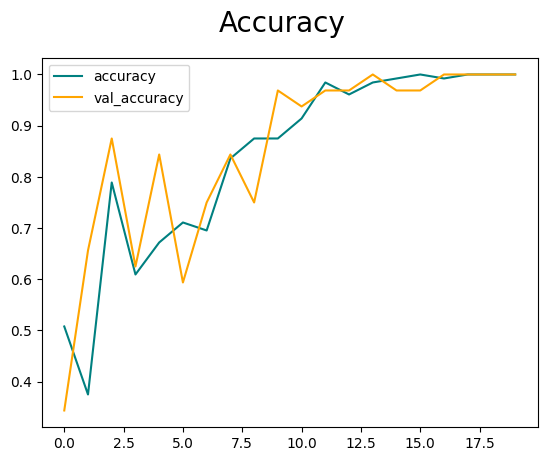

In [26]:
# Créer une nouvelle figure pour le graphique
fig = plt.figure()

# Tracer la courbe de la précision (accuracy) sur l'ensemble d'entraînement
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')  
# Tracer la courbe de la précision (val_accuracy) sur l'ensemble de validation
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')

# Ajouter un titre au graphique
fig.suptitle('Accuracy', fontsize=20)  

# Ajouter une légende dans le coin supérieur gauche du graphique
plt.legend(loc="upper left")

# Afficher le graphique
plt.show()


**6. Evaluate**

**7. Test**

In [38]:
import cv2


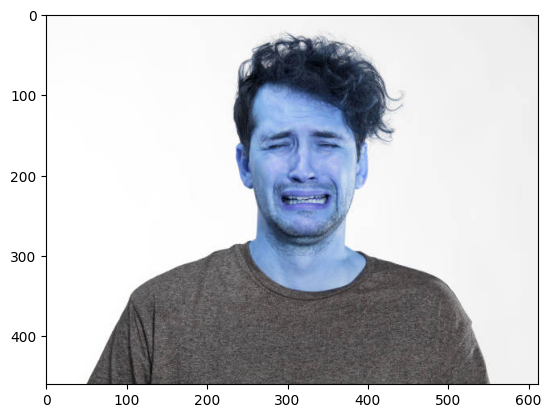

In [43]:
img = cv2.imread('sadtest.jpg')
plt.imshow(img)
plt.show()

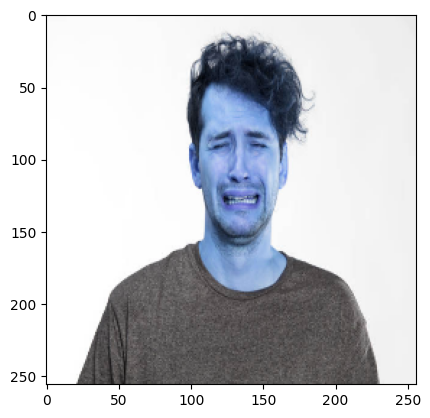

In [44]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [45]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 24ms/step


array([[0.9040401]], dtype=float32)

In [46]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


**8. Save the Model**

In [47]:
from tensorflow.keras.models import load_model

# Saving the model
model.save(os.path.join('models', 'imageclassifier.h5'))

# Loading the model
new_model = load_model('models/imageclassifier.h5')

# Assuming 'resize' is an image resized to the model's input size (e.g., 256x256)
# Normalize and expand dimensions
input_image = np.expand_dims(resize / 255.0, axis=0)

# Predict with the new model
prediction = new_model.predict(input_image)

# Print the prediction result
print(prediction)

1/1 [==============================] - 0s 81ms/step
[[0.9040401]]
